In [ ]:
#Importing libraries
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import json
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/DL/TestDataSet'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Normalization values for ImageNet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Define transform
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])
# Load dataset
dataset_path = "/content/drive/MyDrive/DL/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
                transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [ ]:
# Load the ImageNet class index map from labels_list.json
with open('/content/drive/MyDrive/DL/TestDataSet/labels_list.json') as f:
    label_map = json.load(f)

In [ ]:
# Map dataset class indices (0–99) to actual ImageNet class indices (401–500)
imagenet_indices = [int(entry.split(':')[0]) for entry in label_map]
class_idx_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

In [ ]:
# Evaluate top-1 and top-5 accuracy
def evaluate_model(model, dataloader, class_idx_map):
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            mapped_labels = torch.tensor([class_idx_map[label] for label in labels], dtype=torch.long).to(device)

            outputs = model(images)
            _, pred_top1 = outputs.max(1)
            _, pred_top5 = outputs.topk(5, dim=1)

            top1_correct += (pred_top1 == mapped_labels).sum().item()
            top5_correct += sum([mapped_labels[i].item() in pred_top5[i] for i in range(len(mapped_labels))])
            total += images.size(0)
    return top1_correct / total, top5_correct / total

# Run evaluation
top1, top5 = evaluate_model(model, dataloader, class_idx_map)
print(f"Top-1 Accuracy: {top1:.4f}, Top-5 Accuracy: {top5:.4f}")

Top-1 Accuracy: 0.7600, Top-5 Accuracy: 0.9420


In [ ]:
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(1, 3, 1, 1)
    return tensor * std + mean

def normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(1, 3, 1, 1)
    return (tensor - mean) / std

def get_scaled_epsilon(epsilon_raw=0.02, device='cuda'):
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    return epsilon_raw / std  # per-channel scaling


In [ ]:
# FGSM Attack
def fgsm_attack(model, images, labels, epsilon_raw=0.02):
    eps_scaled = get_scaled_epsilon(epsilon_raw, device=images.device)
    images = images.clone().detach().requires_grad_(True)
    # images.requires_grad = True
    outputs = model(images)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    grad_sign = images.grad.sign()
    if eps_scaled.shape != grad_sign.shape:
        eps_scaled = eps_scaled.expand_as(grad_sign)

    perturbed_images = images + eps_scaled * grad_sign
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images.detach()

# Generate and save Adversarial Test Set 1
adv_set_1 = []
labels_all = []
i = 0
for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = fgsm_attack(model, images, labels, epsilon_raw=0.02)
    # verify_linf_bound(adv_images, images, epsilon=0.02, attack_name="FGSM")
    if i == 0:  # for visualization
      orig_images_fgsm = images.detach().cpu()
      adv_images_fgsm = adv_images.detach().cpu()
    adv_set_1.append(adv_images.cpu())
    labels_all.append(labels.cpu())  # these are still in 0–99 space
    i += 1

adv_set_1 = torch.cat(adv_set_1)
labels_all = torch.cat(labels_all)

# Wrap into TensorDataset and DataLoader

adv_dataset_1 = TensorDataset(adv_set_1, labels_all)
adv_loader_1 = DataLoader(adv_dataset_1, batch_size=16, shuffle=False)

# Evaluate FGSM set
top1_adv1, top5_adv1 = evaluate_model(model, adv_loader_1, class_idx_map)
print(f"[FGSM] Top-1 Accuracy: {top1_adv1:.4f}, Top-5 Accuracy: {top5_adv1:.4f}")


[FGSM] Top-1 Accuracy: 0.3820, Top-5 Accuracy: 0.5960


In [ ]:
# PGD Attack (L∞)
# PGD Attack (L∞) with scaled ε in normalized space, clamped to [0, 1]
def pgd_attack(model, images, labels, epsilon_raw=0.02, alpha_raw=0.005, iters=10):
    eps_scaled = get_scaled_epsilon(epsilon_raw, device=images.device)
    alpha_scaled = get_scaled_epsilon(alpha_raw, device=images.device)

    ori_images = images.clone().detach()
    adv_images = ori_images.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(adv_images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad_sign = adv_images.grad.sign()
        if eps_scaled.shape != grad_sign.shape:
            eps_scaled = eps_scaled.expand_as(grad_sign)
            alpha_scaled = alpha_scaled.expand_as(grad_sign)

        adv_images = adv_images + alpha_scaled * grad_sign

        # Project perturbation into epsilon ball
        perturbation = torch.clamp(adv_images - ori_images, min=-eps_scaled, max=eps_scaled)
        adv_images = torch.clamp(ori_images + perturbation, 0, 1).detach().requires_grad_(True)

    return adv_images.detach()

# Generate and save Adversarial Test Set 2 (PGD)
adv_set_2 = []
labels_all = []

i = 0
for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(model, images, labels)
    if i == 0:  # for visualization
      orig_images_pgd = images.detach().cpu()
      adv_images_pgd = adv_images.detach().cpu()
    adv_set_2.append(adv_images.cpu())
    labels_all.append(labels.cpu())
    i += 1

adv_set_2 = torch.cat(adv_set_2)
labels_all = torch.cat(labels_all)

# Wrap into TensorDataset and DataLoader
adv_dataset_2 = TensorDataset(adv_set_2, labels_all)
adv_loader_2 = DataLoader(adv_dataset_2, batch_size=16, shuffle=False)

# Evaluate PGD adversarial set
top1_adv2, top5_adv2 = evaluate_model(model, adv_loader_2, class_idx_map)
print(f"[PGD] Top-1 Accuracy: {top1_adv2:.4f}, Top-5 Accuracy: {top5_adv2:.4f}")


[PGD] Top-1 Accuracy: 0.4320, Top-5 Accuracy: 0.5640


In [ ]:
# Patch Attack (L0) — applies perturbation to a 32x32 region only
def patch_attack(model, images, labels, epsilon_raw=0.5, patch_size=64):
    # eps_scaled = get_scaled_epsilon(epsilon_raw, device=images.device)

    adv_images = images.clone().detach().requires_grad_(True)
    _, _, H, W = adv_images.shape

    # Random patch coordinates
    x = np.random.randint(0, W - patch_size)
    y = np.random.randint(0, H - patch_size)

    outputs = model(adv_images)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        patch_grad = adv_images.grad[:, :, y:y+patch_size, x:x+patch_size]
        patch = patch_grad.sign() * epsilon_raw
        adv_images[:, :, y:y+patch_size, x:x+patch_size] += patch
        adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images.detach()

# Generate and save Adversarial Test Set 3
adv_set_3 = []
labels_all = []
i = 0
for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = patch_attack(model, images, labels, epsilon_raw=0.5)
    if i == 0:  # for visualization
      orig_images_patch = images.detach().cpu()
      adv_images_patch = adv_images.detach().cpu()
    adv_set_3.append(adv_images.cpu())
    labels_all.append(labels.cpu())
    i += 1


adv_set_3 = torch.cat(adv_set_3)
labels_all = torch.cat(labels_all)

adv_dataset_3 = TensorDataset(adv_set_3, labels_all)
adv_loader_3 = DataLoader(adv_dataset_3, batch_size=16, shuffle=False)

# Evaluate patch attack set
top1_adv3, top5_adv3 = evaluate_model(model, adv_loader_3, class_idx_map)
print(f"[Patch] Top-1 Accuracy: {top1_adv3:.4f}, Top-5 Accuracy: {top5_adv3:.4f}")


[Patch] Top-1 Accuracy: 0.3480, Top-5 Accuracy: 0.5360


In [ ]:
# Load another model
densenet_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
densenet_model.eval()

# Evaluate on all datasets
top1_orig, top5_orig = evaluate_model(densenet_model, dataloader, class_idx_map)
top1_d1, top5_d1 = evaluate_model(densenet_model, adv_loader_1,class_idx_map )
top1_d2, top5_d2 = evaluate_model(densenet_model, adv_loader_2, class_idx_map)
top1_d3, top5_d3 = evaluate_model(densenet_model, adv_loader_3, class_idx_map)

print("\n[Transfer to DenseNet-121]")
print(f"Original     - Top-1: {top1_orig:.4f}, Top-5: {top5_orig:.4f}")
print(f"FGSM         - Top-1: {top1_d1:.4f}, Top-5: {top5_d1:.4f}")
print(f"PGD          - Top-1: {top1_d2:.4f}, Top-5: {top5_d2:.4f}")
print(f"Patch Attack - Top-1: {top1_d3:.4f}, Top-5: {top5_d3:.4f}")



[Transfer to DenseNet-121]
Original     - Top-1: 0.7480, Top-5: 0.9360
FGSM         - Top-1: 0.4720, Top-5: 0.6940
PGD          - Top-1: 0.5100, Top-5: 0.7020
Patch Attack - Top-1: 0.4280, Top-5: 0.6540


In [ ]:
print("\nFinal Evaluation Summary\n")
print(f"ResNet-34 - Original     Top-1: {top1:.4f}, Top-5: {top5:.4f}")
print(f"ResNet-34 - FGSM         Top-1: {top1_adv1:.4f}, Top-5: {top5_adv1:.4f}")
print(f"ResNet-34 - PGD          Top-1: {top1_adv2:.4f}, Top-5: {top5_adv2:.4f}")
print(f"ResNet-34 - Patch        Top-1: {top1_adv3:.4f}, Top-5: {top5_adv3:.4f}")

print(f"\nDenseNet-121 - Original  Top-1: {top1_orig:.4f}, Top-5: {top5_orig:.4f}")
print(f"DenseNet-121 - FGSM      Top-1: {top1_d1:.4f}, Top-5: {top5_d1:.4f}")
print(f"DenseNet-121 - PGD       Top-1: {top1_d2:.4f}, Top-5: {top5_d2:.4f}")
print(f"DenseNet-121 - Patch     Top-1: {top1_d3:.4f}, Top-5: {top5_d3:.4f}")



Final Evaluation Summary

ResNet-34 - Original     Top-1: 0.7600, Top-5: 0.9420
ResNet-34 - FGSM         Top-1: 0.3820, Top-5: 0.5960
ResNet-34 - PGD          Top-1: 0.4320, Top-5: 0.5640
ResNet-34 - Patch        Top-1: 0.3480, Top-5: 0.5360

DenseNet-121 - Original  Top-1: 0.7480, Top-5: 0.9360
DenseNet-121 - FGSM      Top-1: 0.4720, Top-5: 0.6940
DenseNet-121 - PGD       Top-1: 0.5100, Top-5: 0.7020
DenseNet-121 - Patch     Top-1: 0.4280, Top-5: 0.6540


In [18]:
def tensor_to_numpy(img_tensor):
    img = img_tensor.clone().detach().cpu()
    img = img.squeeze(0) if img.ndim == 4 else img
    img = img.permute(1, 2, 0)  # CxHxW to HxWxC
    img = img * torch.tensor(std_norms) + torch.tensor(mean_norms)
    img = torch.clamp(img, 0, 1).numpy()
    return img

def get_top5_predictions(model, image_tensor):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
        probs = F.softmax(output, dim=1)
        top5_probs, top5_indices = probs.topk(5)
    return top5_indices.squeeze(0).tolist(), top5_probs.squeeze(0).tolist()

def plot_adversarial_analysis(original, adversarial, model, idx=0, label_map=None, attack_name="", method_name=""):
    orig_img = original[idx]
    adv_img = adversarial[idx]

    # Denormalize
    orig_np = tensor_to_numpy(orig_img)
    adv_np = tensor_to_numpy(adv_img)

    # Compute scaled noise
    noise = adv_img - orig_img
    noise_scaled = (noise - noise.min()) / (noise.max() - noise.min())
    noise_np = noise_scaled.permute(1, 2, 0).cpu().numpy()

    # Get predictions
    top5_idx, top5_conf = get_top5_predictions(model, adv_img)
    top5_labels = [str(i) for i in top5_idx]
    if label_map:
        top5_labels = [label_map.get(i, str(i)) for i in top5_idx]

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    fig.suptitle(f"{method_name} — {attack_name} Attack — Sample #{idx}", fontsize=16, fontweight='bold')

    axs[0].imshow(orig_np)
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(adv_np)
    axs[1].set_title("Adversarial")
    axs[1].axis('off')

    axs[2].imshow(noise_np)
    axs[2].set_title("Noise (scaled)")
    axs[2].axis('off')

    axs[3].barh(range(5), top5_conf, color='blue')
    axs[3].set_yticks(range(5))
    axs[3].set_yticklabels(top5_labels)
    axs[3].invert_yaxis()
    axs[3].set_title("Top-5 Predictions")
    axs[3].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


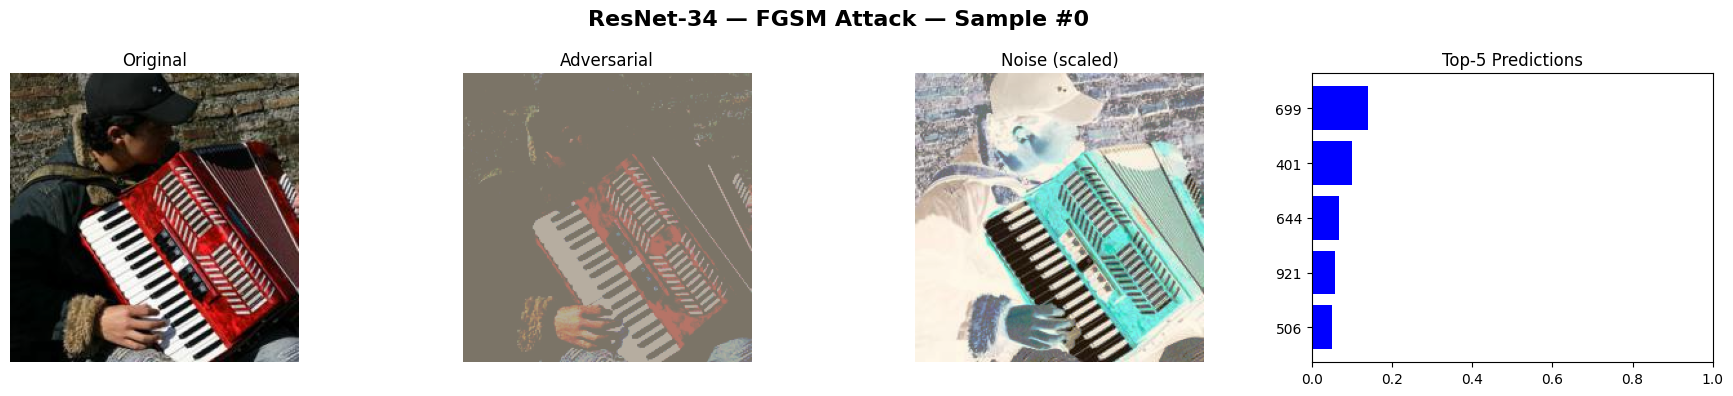

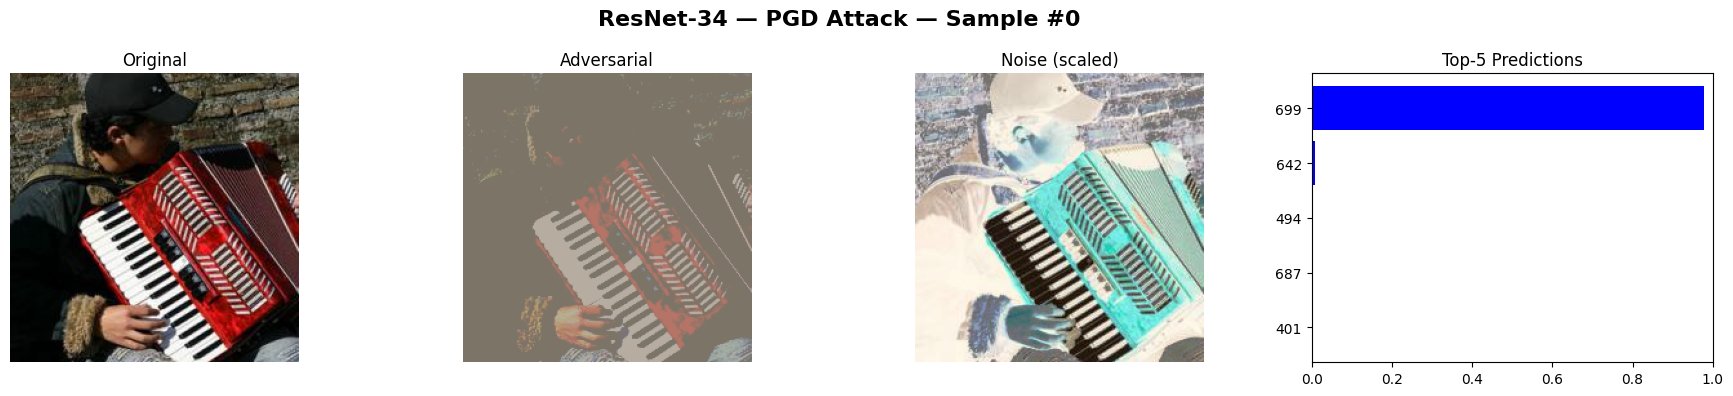

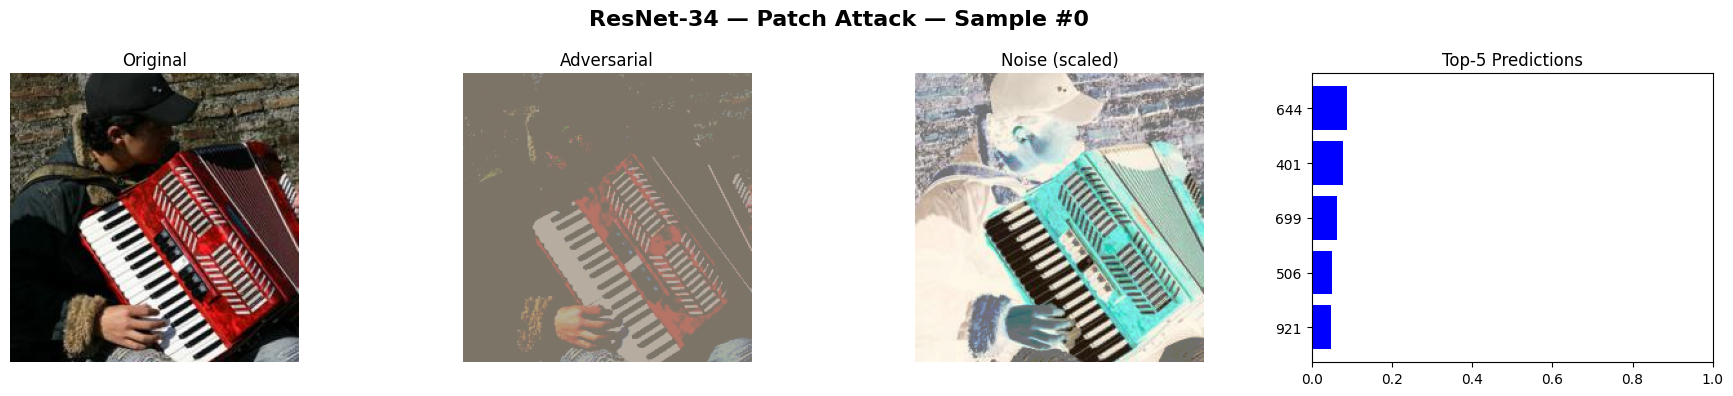

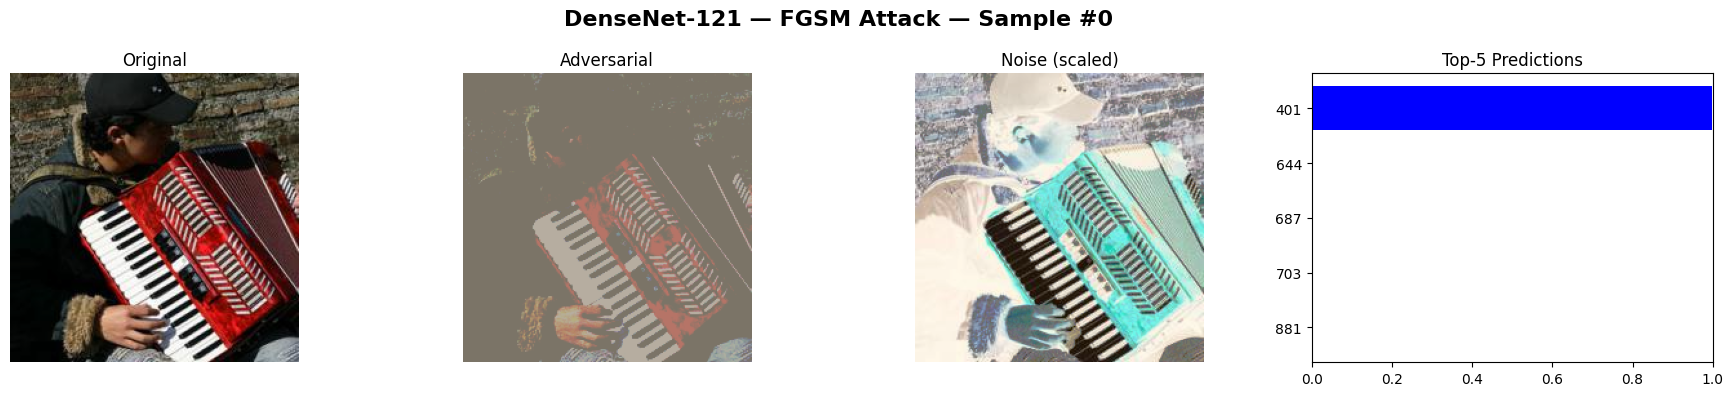

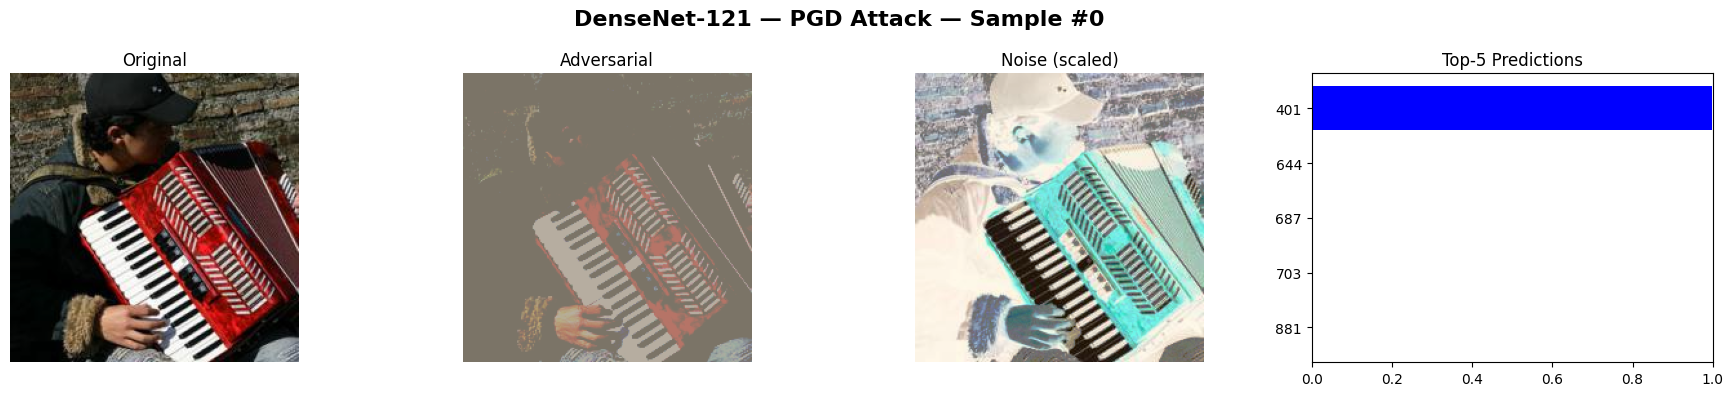

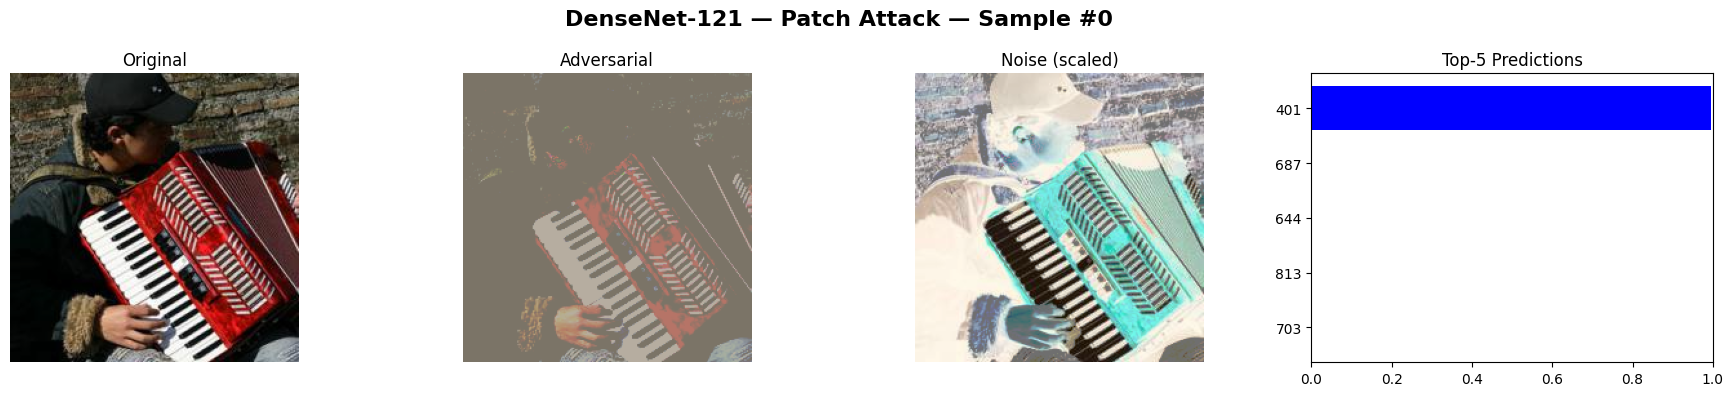

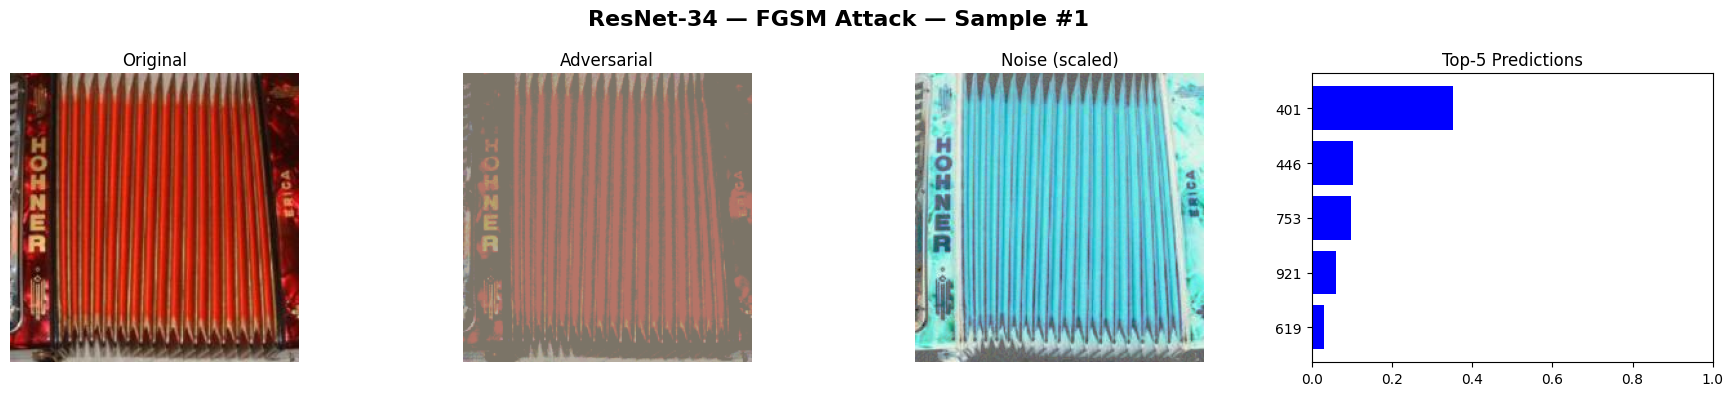

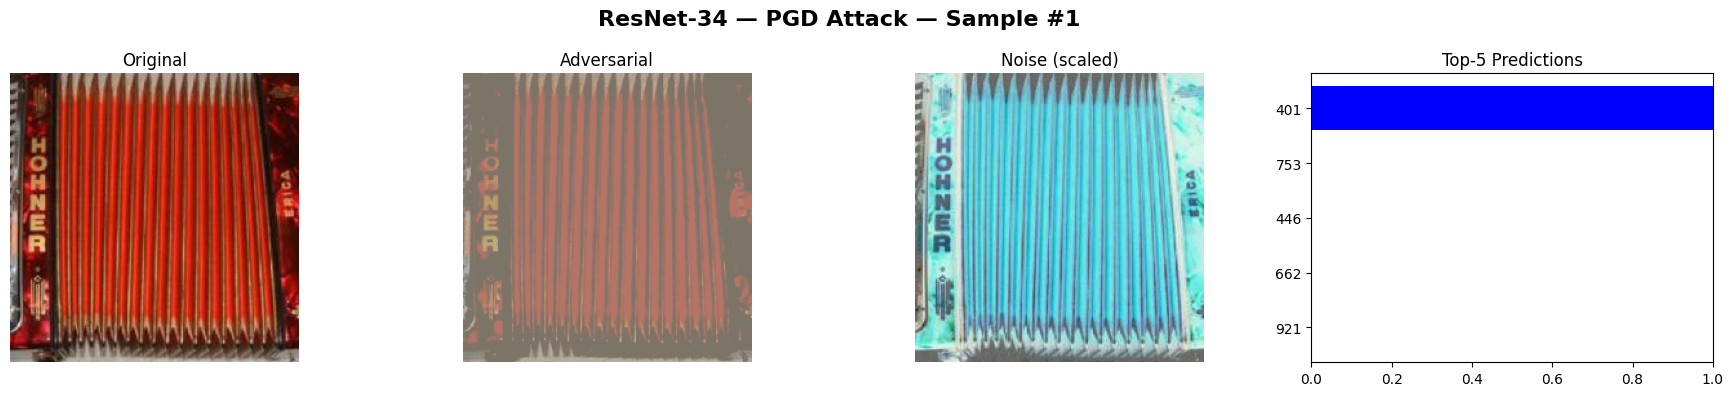

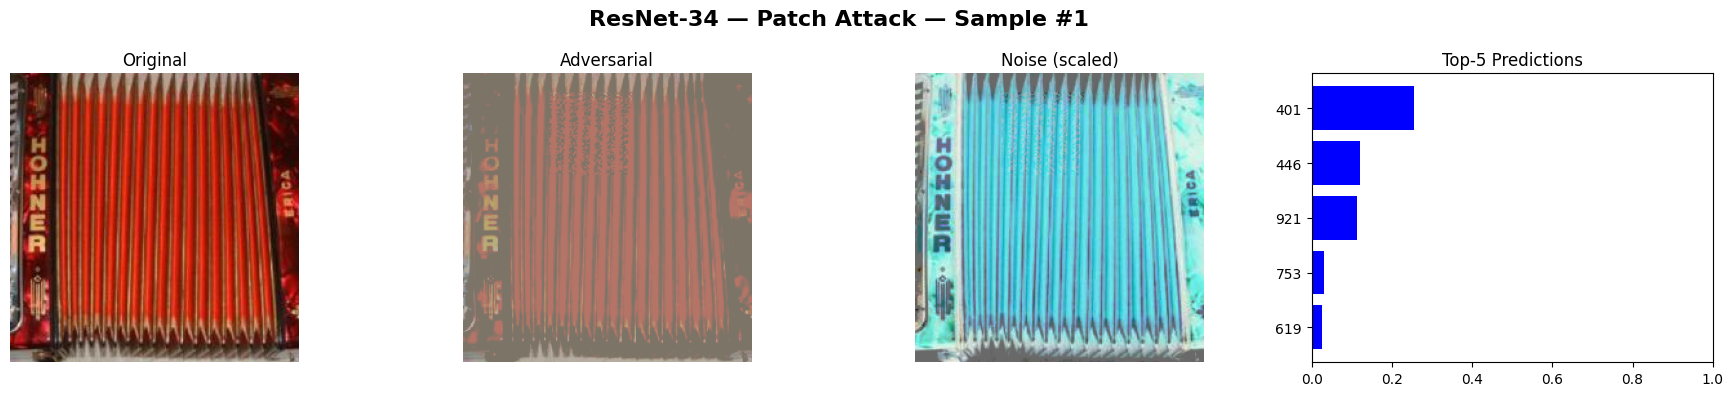

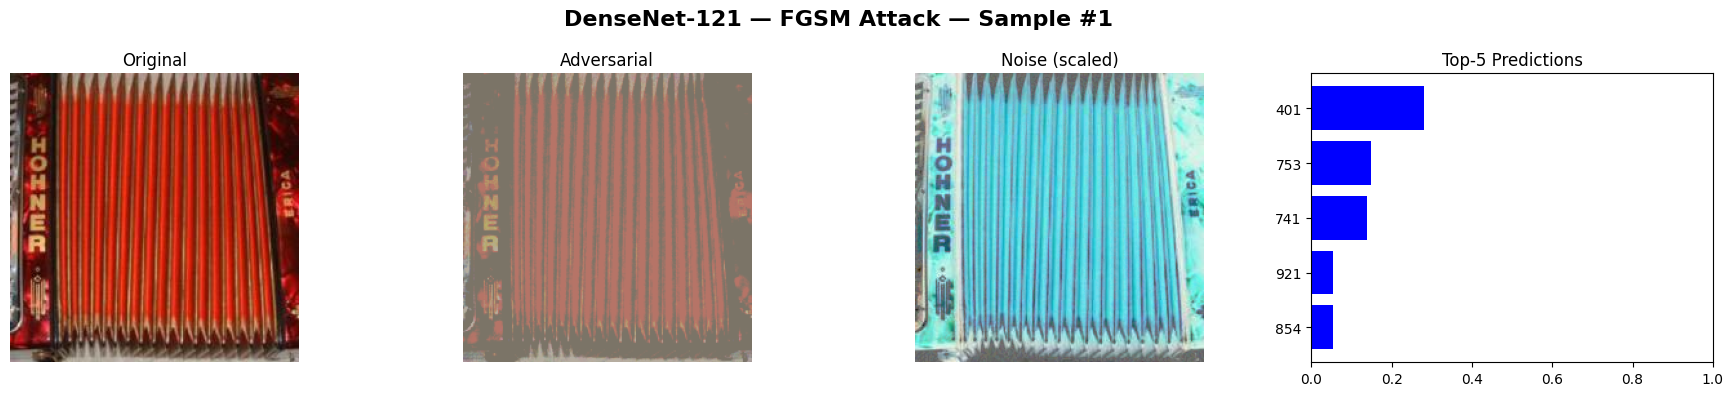

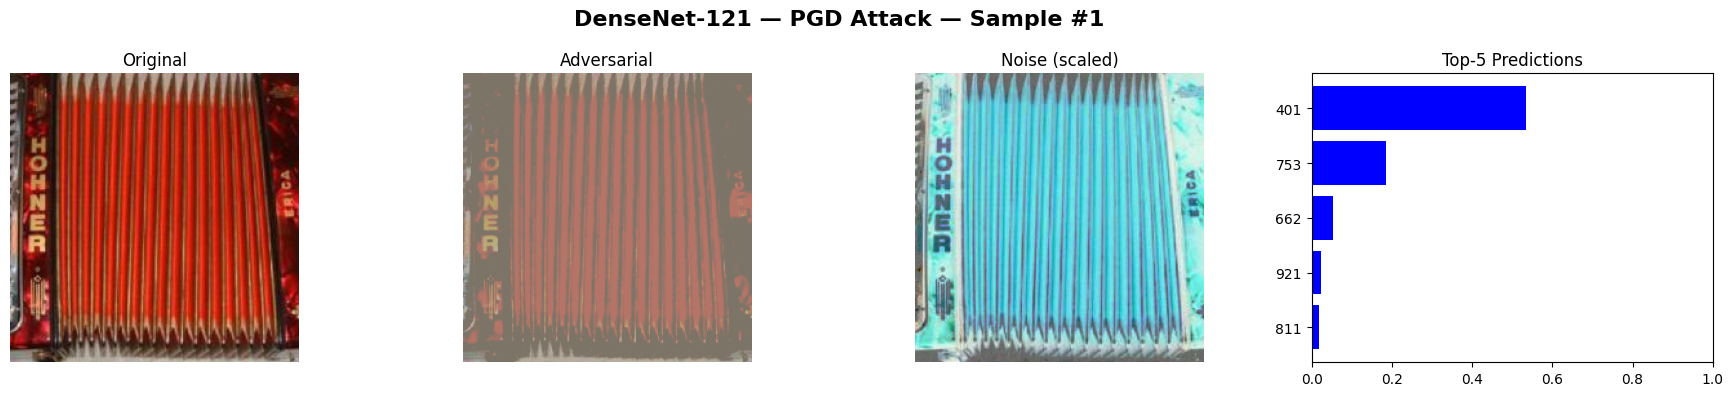

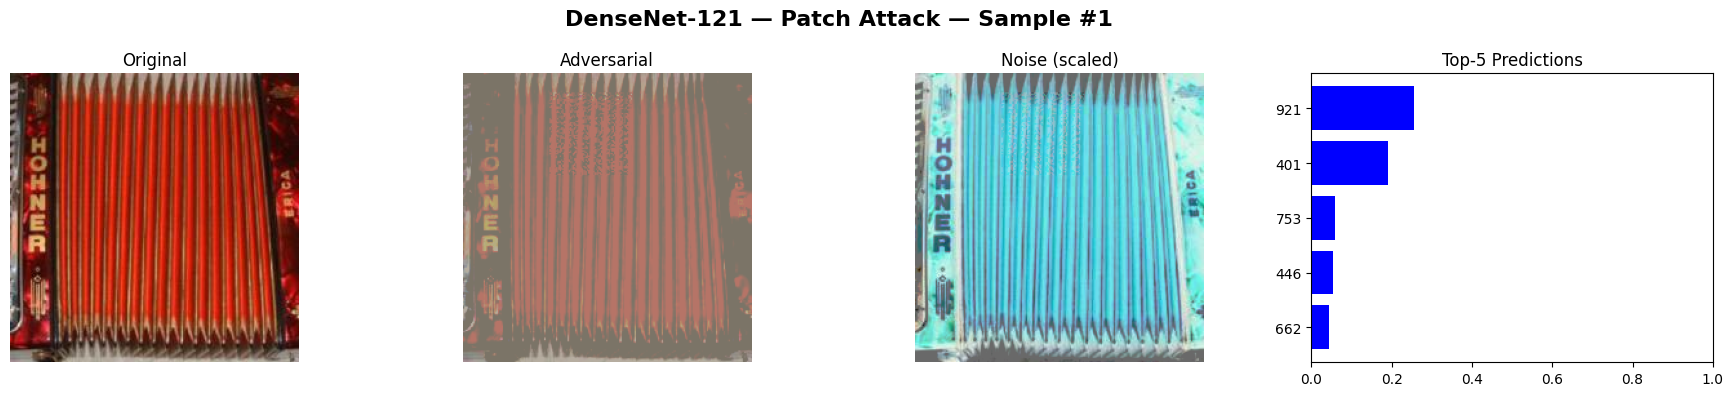

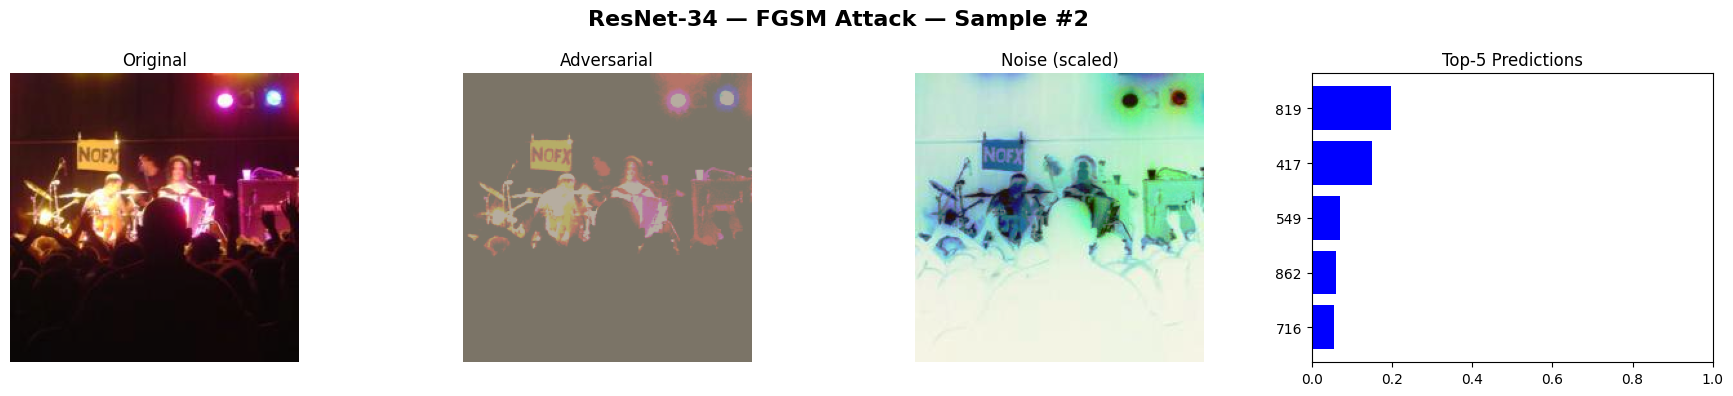

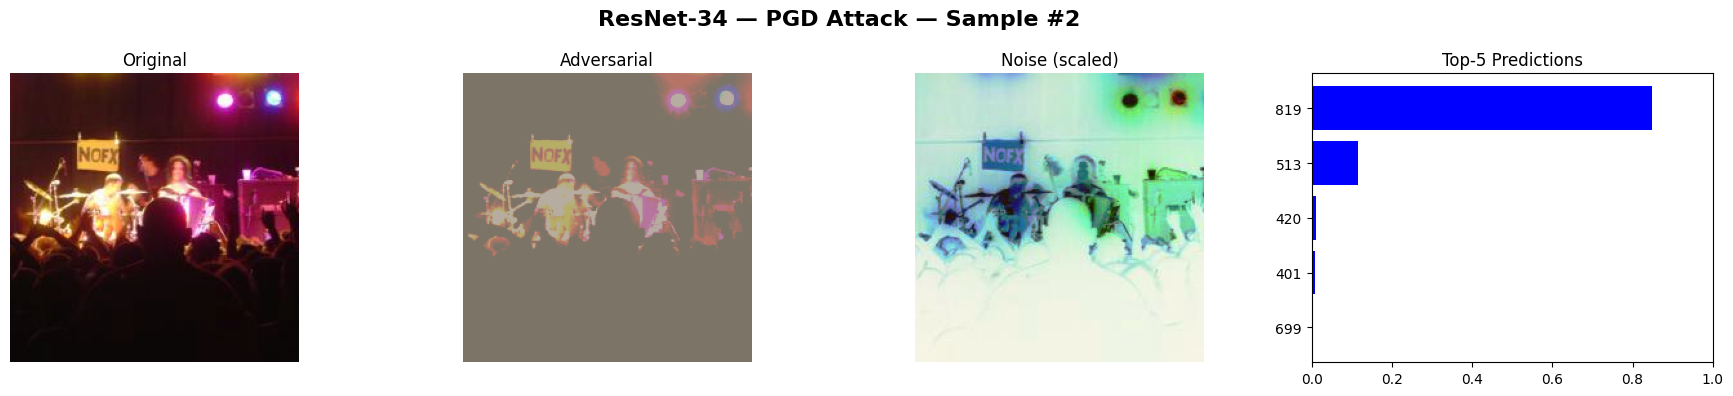

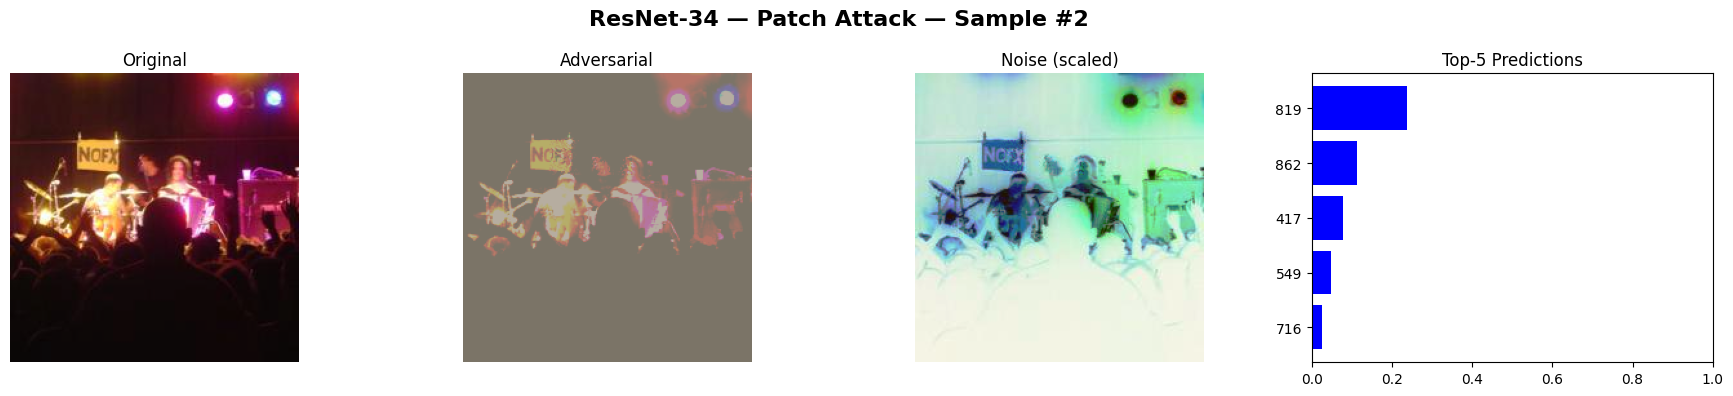

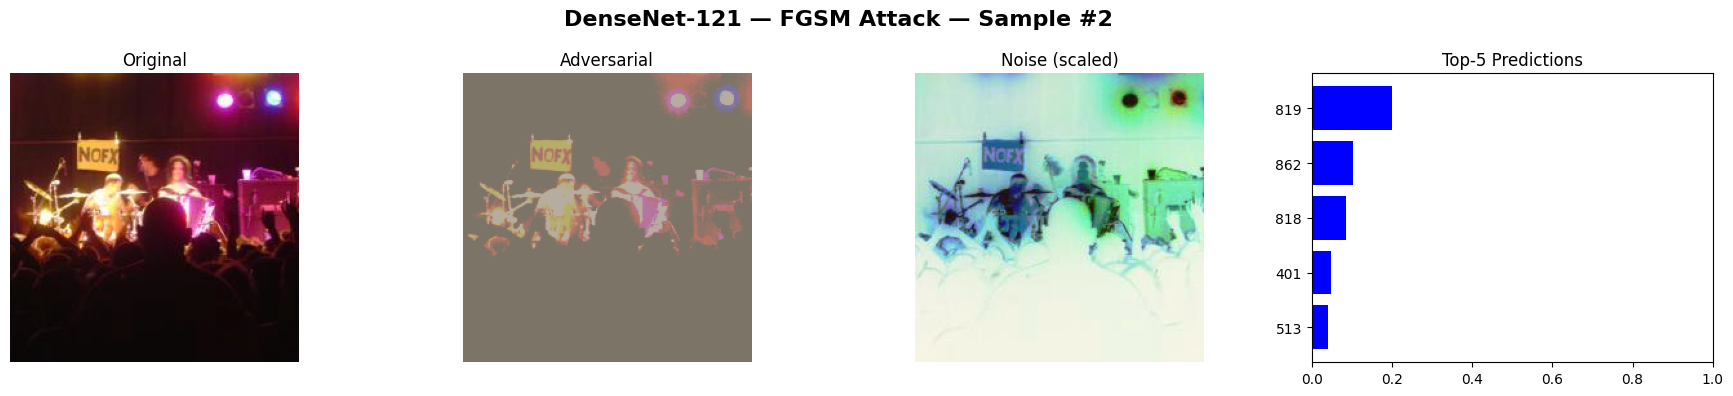

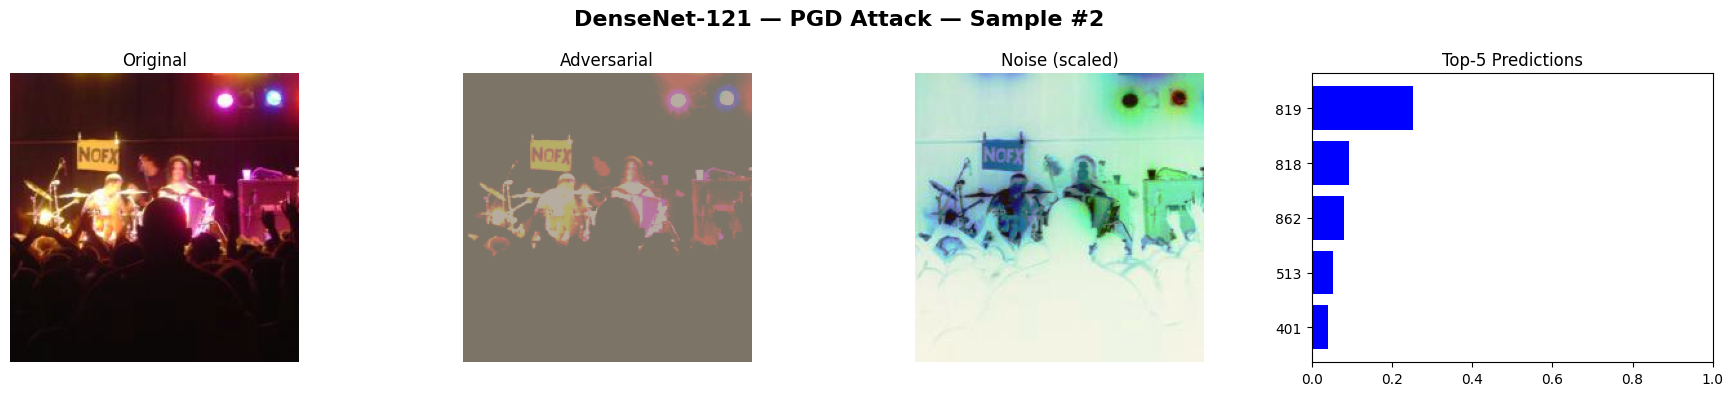

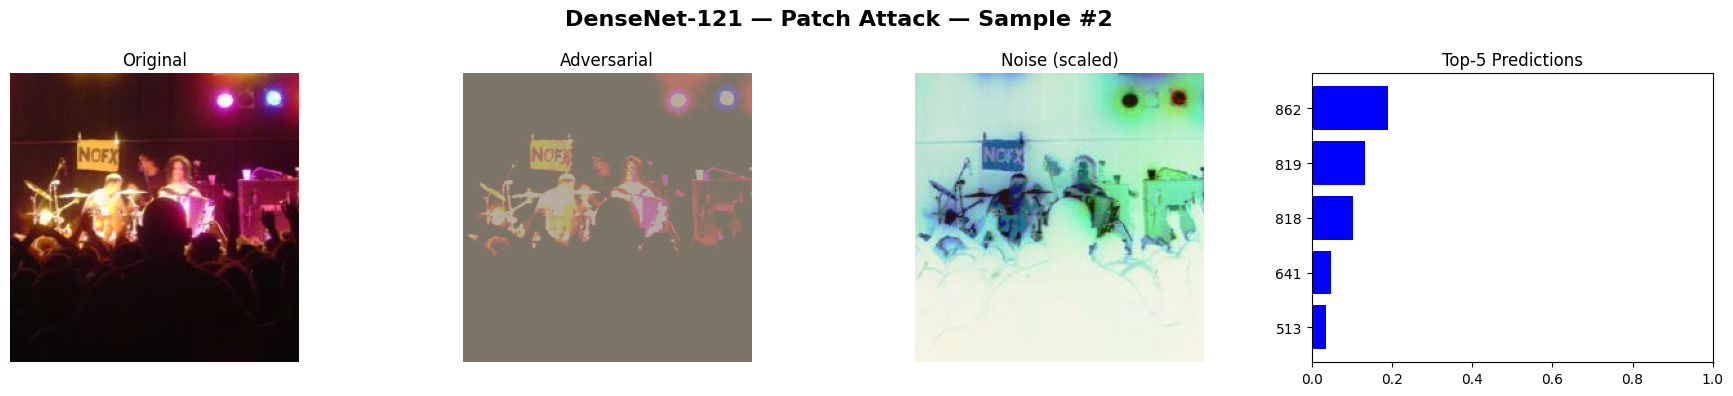

In [20]:
for i in range(3):
    # ResNet-34
    plot_adversarial_analysis(orig_images_fgsm, adv_images_fgsm, model, idx=i, label_map=class_idx_map, attack_name="FGSM", method_name="ResNet-34")
    plot_adversarial_analysis(orig_images_pgd, adv_images_pgd, model, idx=i, label_map=class_idx_map, attack_name="PGD", method_name="ResNet-34")
    plot_adversarial_analysis(orig_images_patch, adv_images_patch, model, idx=i, label_map=class_idx_map, attack_name="Patch", method_name="ResNet-34")

    # DenseNet-121
    plot_adversarial_analysis(orig_images_fgsm, adv_images_fgsm, densenet_model, idx=i, label_map=class_idx_map, attack_name="FGSM", method_name="DenseNet-121")
    plot_adversarial_analysis(orig_images_pgd, adv_images_pgd, densenet_model, idx=i, label_map=class_idx_map, attack_name="PGD", method_name="DenseNet-121")
    plot_adversarial_analysis(orig_images_patch, adv_images_patch, densenet_model, idx=i, label_map=class_idx_map, attack_name="Patch", method_name="DenseNet-121")

